In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt 

In [2]:
df = pd.read_csv("../../database/csv_file/data_without_noise/cleandataVereMi/cleandataVereMi.csv")
df

,type,rcvTime,sendTime,sender,messageID,RSSI,attackerType,pos_x,pos_y,pos_z,spd_x,spd_y,spd_z,global_pos,global_spd
0,3,10800.392893,10800.392785,13,38,1.115287e-07,0,3597.152086,5542.199221,1.895,-3.178366,38.798969,0.0,6607.229293,38.928936
1,3,10800.456258,10800.456150,31,104,3.218740e-09,0,3596.805861,5692.113417,1.895,1.282467,-29.864003,0.0,6733.288286,29.891527
2,3,10800.582131,10800.582020,25,137,2.900248e-09,0,3597.770493,5764.800893,1.895,-0.020161,-34.568848,0.0,6795.357639,34.568854
3,3,10800.670748,10800.670638,43,172,1.746131e-08,0,3822.892006,5266.806009,1.895,1.305362,-0.988730,0.0,6507.976062,1.637546
4,3,10800.870128,10800.870012,19,193,3.710398e-07,0,3617.100034,5417.782781,1.895,4.937950,-39.877578,0.0,6514.275594,40.182143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55607,3,10814.026618,10814.026510,73,3676,1.983451e-09,0,3772.690397,5812.521758,1.895,-0.020093,-34.522519,0.0,6929.545844,34.522525
55608,3,10814.323660,10814.323541,67,3694,2.203141e-09,0,3972.947393,5263.193766,1.895,14.048681,1.808117,0.0,6594.355404,14.164559
55609,3,10800.079764,10800.079645,19,58,2.339278e-09,0,3613.826325,5505.799698,1.895,3.095704,-36.770480,0.0,6585.861722,36.900563
55610,3,10800.204760,10800.204649,7,162,6.183666e-08,0,3589.017816,5917.005804,1.895,1.435204,33.709079,0.0,6920.405347,33.739618


In [14]:
df["attackerType"].unique()

array([ 0, 16,  1,  2,  4,  8], dtype=int64)

In [18]:
def len_array_atacker_type_value(value):
    result = len(df[df["attackerType"] == value])
    return result

attackTypeArray = [0, 1, 4, 8, 16]

for attack in attackTypeArray:
    print(attack, " : ", len_array_atacker_type_value(attack), "\n")

0  :  50514 

1  :  723 

4  :  954 

8  :  1567 

16  :  1131 



In [4]:
X = df.drop(["attackerType"], axis = 1)
Y = df["attackerType"]

# PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
PCA_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2'])
PCA_df = pd.concat([PCA_df, df['class']], axis = 1)
PCA_df['class'] = LabelEncoder().fit_transform(PCA_df['class'])
PCA_df.head()

# Autoencoder

In [44]:
print(type(X.shape[1]))

<class 'int'>


In [43]:
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split

input_layer = Input(shape=(X.shape[1],))

encoded = Dense(X.shape[1], activation='relu')(input_layer)
intermediaire = Dense(7, activation='relu')(encoded)
decoded = Dense(X.shape[1], activation='softmax')(intermediaire)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

X1, X2, Y1, Y2 = train_test_split(X, X, test_size=0.3, random_state=101)

autoencoder.fit(X1, Y1,
                epochs=100,
                batch_size=300,
                shuffle=True,
                verbose = 30,
                validation_data=(X2, Y2))

encoder = Model(input_layer, encoded)
X_ae = encoder.predict(X)
X_autoencoded = pd.DataFrame(X_ae)

AttributeError: 'Functional' object has no attribute 'shape'

In [32]:
X_ae.shape

(55612, 14)

# Model LSTM

In [36]:
X_autoencoded = pd.DataFrame(X_ae)
type(X_autoencoded)

pandas.core.frame.DataFrame

In [34]:
from keras.models import Sequential
from keras.layers import Dense
import numpy as np

import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU
from keras.layers import Dropout
from keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

In [38]:
XReshape=X_autoencoded.values.reshape((X_autoencoded.values.shape[0], X_autoencoded.values.shape[1], 1))
X_train, X_test, y_train, y_test = train_test_split(XReshape, Y, test_size = 0.2, random_state = 42)


In [42]:
model=Sequential()

model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.2), input_shape=(14,1), activation='relu'))
model.add(LSTM(32, activation='relu', kernel_regularizer=l2(0.2)))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])


# train the model 
h = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=10)

Epoch 1/10
1391/1391 [==============================] - 11s 8ms/step - loss: 6.8411 - accuracy: 0.0131 - val_loss: 4.9385 - val_accuracy: 0.0125
Epoch 2/10
1391/1391 [==============================] - 11s 8ms/step - loss: 5.2762 - accuracy: 0.0131 - val_loss: 4.9382 - val_accuracy: 0.0125
Epoch 3/10
1391/1391 [==============================] - 11s 8ms/step - loss: 5.2762 - accuracy: 0.0131 - val_loss: 4.9382 - val_accuracy: 0.0125
Epoch 4/10
1391/1391 [==============================] - 10s 7ms/step - loss: 5.2762 - accuracy: 0.0131 - val_loss: 4.9382 - val_accuracy: 0.0125
Epoch 5/10
1391/1391 [==============================] - 11s 8ms/step - loss: 5.2762 - accuracy: 0.0131 - val_loss: 4.9382 - val_accuracy: 0.0125
Epoch 6/10
1391/1391 [==============================] - 11s 8ms/step - loss: 5.2762 - accuracy: 0.0131 - val_loss: 4.9382 - val_accuracy: 0.0125
Epoch 7/10
1391/1391 [==============================] - 11s 8ms/step - loss: 5.2762 - accuracy: 0.0131 - val_loss: 4.9382 - val_ac

# result 

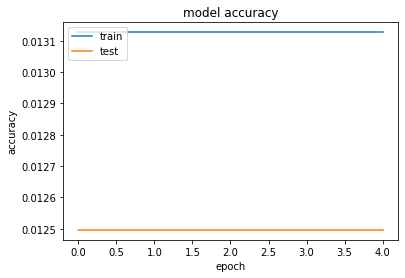

In [40]:
# accuracy
plt.plot(h.history['accuracy'])
plt.plot(h.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()

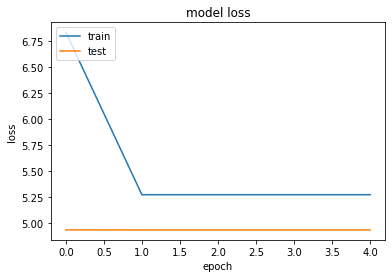

In [41]:
# loss value
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc = 'upper left')
plt.show()